In [ ]:
!pip install google-cloud-storage
!pip install pandas

In [1]:
from google.cloud import storage
import pandas as pd

bucket_name = "nobu_w266_final_project"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

# When you have your files in a subfolder of the bucket.
my_prefix = "OECD_US_file/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        blob.download_to_filename(file_name) # download the file to the machine
        df = pd.read_csv(file_name, delimiter="|") # load the data
        print(df)

          appln_id       pub_nbr  filing  tech_field  many_field  \
0         49683821    US03951277    1976          25           0   
1         48696358    US03956062    1976          27           0   
2         51805403    US03960276    1976          25           0   
3         51041941    US03963460    1976          24           1   
4         51841776    US03963546    1976          26           0   
...            ...           ...     ...         ...         ...   
8574380  516842427  US2019230828    2019           1           1   
8574381  516842321  US2019230829    2016           2           0   
8574382  516842367  US2019230830    2016           2           0   
8574383  516851404  US2019230831    2016          25           1   
8574384  516851330  US2019230832    2016           2           1   

         patent_scope  family_size  grant_lag  bwd_cits  npl_cits  ...  \
0                   1            5      106.0         5         0  ...   
1                   1            1 

In [2]:
# Now try to pull the patent data combining 2 files to accumulate 1 year
from google.cloud import storage
import pandas as pd

bucket_name = "nobu_w266_final_project"

storage_client = storage.Client()
bucket = storage_client.get_bucket(bucket_name)

# When you have your files in a subfolder of the bucket.
my_prefix = "Patent_US/" # the name of the subfolder
blobs = bucket.list_blobs(prefix = my_prefix, delimiter = '/')

patent_data_combine = None

for blob in blobs:
    if(blob.name != my_prefix): # ignoring the subfolder itself 
        file_name = blob.name.replace(my_prefix, "")
        blob.download_to_filename(file_name) # download the file to the machine
        patent_data = pd.read_csv(file_name) # load the data
        # print(patent_data)
        if patent_data_combine is None:
            patent_data_combine = patent_data
        else:
            patent_data_combine = patent_data_combine.append(patent_data)

In [3]:
patent_data_combine.head()

,publication_number,abstract_text,filing_date,title_text,claims_text
0,US-10073820-B2,A method executed on an access device includes...,20101231,"Systems, methods, and interfaces for paginatio...",The invention claimed is: \n \n 1. A...
1,US-10073820-B2,A method executed on an access device includes...,20101231,"Systems, methods, and interfaces for paginatio...",The invention claimed is: \n \n 1. A...
2,US-10174730-B2,A fuel injector for use in delivering fuel to ...,20100722,Fuel injector,The invention claimed is: \n \n 1. A...
3,US-10174730-B2,A fuel injector for use in delivering fuel to ...,20100722,Fuel injector,The invention claimed is: \n \n 1. A...
4,US-9111098-B2,An asset management system is provided which c...,20100712,System and method for managing electronic assets,The invention claimed is: \n \n 1. A...


In [4]:
patent_data_combine['publication_number_match'] = 'US0' + patent_data_combine['publication_number'].str[3:-3]

### drop duplicated rows

In [5]:
patent_data_combine.drop_duplicates(subset='publication_number_match', keep = 'first', inplace = True)
patent_data_combine

,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match
0,US-10073820-B2,A method executed on an access device includes...,20101231,"Systems, methods, and interfaces for paginatio...",The invention claimed is: \n \n 1. A...,US010073820
2,US-10174730-B2,A fuel injector for use in delivering fuel to ...,20100722,Fuel injector,The invention claimed is: \n \n 1. A...,US010174730
4,US-9111098-B2,An asset management system is provided which c...,20100712,System and method for managing electronic assets,The invention claimed is: \n \n 1. A...,US09111098
5,US-9276710-B2,Techniques for supporting communication with c...,20101209,Method and apparatus for resource allocation w...,What is claimed is: \n \n 1. A metho...,US09276710
6,US-9353996-B2,A pressure difference driven heat spreader inc...,20100830,Pressure difference driven heat spreader,What is claimed is: \n \n 1. A press...,US09353996
...,...,...,...,...,...,...
105196,US-9420880-B2,An apparatus and assembly for selecting inform...,20141217,Personal control apparatus and method for shar...,What is claimed is: \n \n 1. An appa...,US09420880
105197,US-9610188-B2,An Unloader assembly to control load distribut...,20140918,VRB cantilever-based unloader brace assembly,What is claimed is: \n \n 1. An exos...,US09610188
105198,US-9222119-B2,Provided herein are compositions useful in det...,20141211,Detection of degradative enzymes and biomolecu...,What is claimed is: \n \n 1. A pepti...,US09222119
105199,US-9253843-B2,"A driving circuit includes a power converter, ...",20141008,Driving circuit with dimming controller for dr...,What is claimed is: \n \n 1. A dimmi...,US09253843


### merge two daraframes

In [6]:
df_merge = pd.merge(patent_data_combine, df, left_on='publication_number_match', right_on='pub_nbr', how='inner')
df_merge

,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,tech_field,...,claims_bwd,fwd_cits5,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6
0,US-9111098-B2,An asset management system is provided which c...,20100712,System and method for managing electronic assets,The invention claimed is: \n \n 1. A...,US09111098,330389907,US09111098,2010,6,...,NaN,18,42,0,0.657428,0.921539,0.550505,5.0,0.419565,0.372142
1,US-9276710-B2,Techniques for supporting communication with c...,20101209,Method and apparatus for resource allocation w...,What is claimed is: \n \n 1. A metho...,US09276710,340923572,US09276710,2010,4,...,NaN,26,27,0,0.545600,0.919802,0.269565,6.0,0.469674,0.441058
2,US-9353996-B2,A pressure difference driven heat spreader inc...,20100830,Pressure difference driven heat spreader,What is claimed is: \n \n 1. A press...,US09353996,341089247,US09353996,2010,30,...,NaN,1,3,0,0.693878,0.786704,0.157895,6.0,0.327714,0.273524
3,US-9289847-B2,A manufacturing method for a module having a h...,20100903,Method for manufacturing a module with a hollo...,The invention claimed is: \n \n 1. A...,US09289847,364666123,US09289847,2010,26,...,NaN,2,2,0,0.835000,0.910671,0.373134,6.0,0.434408,0.352743
4,US-9215628-B2,A method and a system for processing a Radio L...,20100928,Method for processing radio link failure repor...,What is claimed is: \n \n 1. A metho...,US09215628,333088623,US09215628,2010,4,...,NaN,37,45,0,0.157116,0.877355,0.327273,5.0,0.228800,0.221936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103518,US-9420880-B2,An apparatus and assembly for selecting inform...,20141217,Personal control apparatus and method for shar...,What is claimed is: \n \n 1. An appa...,US09420880,438915249,US09420880,2014,2,...,NaN,64,64,0,0.899696,0.947995,0.400990,2.0,0.626386,0.664832
1103519,US-9610188-B2,An Unloader assembly to control load distribut...,20140918,VRB cantilever-based unloader brace assembly,What is claimed is: \n \n 1. An exos...,US09610188,437249681,US09610188,2014,33,...,NaN,5,5,0,0.751378,NaN,NaN,3.0,0.343247,0.309766
1103520,US-9222119-B2,Provided herein are compositions useful in det...,20141211,Detection of degradative enzymes and biomolecu...,What is claimed is: \n \n 1. A pepti...,US09222119,438541243,US09222119,2014,15,...,NaN,4,4,0,0.719835,0.901745,0.348485,1.0,0.215744,0.288046
1103521,US-9253843-B2,"A driving circuit includes a power converter, ...",20141008,Driving circuit with dimming controller for dr...,What is claimed is: \n \n 1. A dimmi...,US09253843,425720739,US09253843,2014,1,...,NaN,2,2,0,0.750000,0.869645,0.515748,2.0,0.476945,0.556583


### keep only quality_index_4 >= 0

In [7]:
df_merge_quality = df_merge[(df_merge['quality_index_4'] >=0) & (len(df_merge['title_text']) >0) & (len(df_merge['abstract_text']) >0) & (len(df_merge['claims_text']) >0)]

In [8]:
df_merge_quality

,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,tech_field,...,claims_bwd,fwd_cits5,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6
0,US-9111098-B2,An asset management system is provided which c...,20100712,System and method for managing electronic assets,The invention claimed is: \n \n 1. A...,US09111098,330389907,US09111098,2010,6,...,NaN,18,42,0,0.657428,0.921539,0.550505,5.0,0.419565,0.372142
1,US-9276710-B2,Techniques for supporting communication with c...,20101209,Method and apparatus for resource allocation w...,What is claimed is: \n \n 1. A metho...,US09276710,340923572,US09276710,2010,4,...,NaN,26,27,0,0.545600,0.919802,0.269565,6.0,0.469674,0.441058
2,US-9353996-B2,A pressure difference driven heat spreader inc...,20100830,Pressure difference driven heat spreader,What is claimed is: \n \n 1. A press...,US09353996,341089247,US09353996,2010,30,...,NaN,1,3,0,0.693878,0.786704,0.157895,6.0,0.327714,0.273524
3,US-9289847-B2,A manufacturing method for a module having a h...,20100903,Method for manufacturing a module with a hollo...,The invention claimed is: \n \n 1. A...,US09289847,364666123,US09289847,2010,26,...,NaN,2,2,0,0.835000,0.910671,0.373134,6.0,0.434408,0.352743
4,US-9215628-B2,A method and a system for processing a Radio L...,20100928,Method for processing radio link failure repor...,What is claimed is: \n \n 1. A metho...,US09215628,333088623,US09215628,2010,4,...,NaN,37,45,0,0.157116,0.877355,0.327273,5.0,0.228800,0.221936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103518,US-9420880-B2,An apparatus and assembly for selecting inform...,20141217,Personal control apparatus and method for shar...,What is claimed is: \n \n 1. An appa...,US09420880,438915249,US09420880,2014,2,...,NaN,64,64,0,0.899696,0.947995,0.400990,2.0,0.626386,0.664832
1103519,US-9610188-B2,An Unloader assembly to control load distribut...,20140918,VRB cantilever-based unloader brace assembly,What is claimed is: \n \n 1. An exos...,US09610188,437249681,US09610188,2014,33,...,NaN,5,5,0,0.751378,NaN,NaN,3.0,0.343247,0.309766
1103520,US-9222119-B2,Provided herein are compositions useful in det...,20141211,Detection of degradative enzymes and biomolecu...,What is claimed is: \n \n 1. A pepti...,US09222119,438541243,US09222119,2014,15,...,NaN,4,4,0,0.719835,0.901745,0.348485,1.0,0.215744,0.288046
1103521,US-9253843-B2,"A driving circuit includes a power converter, ...",20141008,Driving circuit with dimming controller for dr...,What is claimed is: \n \n 1. A dimmi...,US09253843,425720739,US09253843,2014,1,...,NaN,2,2,0,0.750000,0.869645,0.515748,2.0,0.476945,0.556583


In [9]:
max(df_merge_quality['quality_index_4'])

0.9838762663797841

In [10]:
min(df_merge_quality['quality_index_4'])

0.0128657793131477

In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

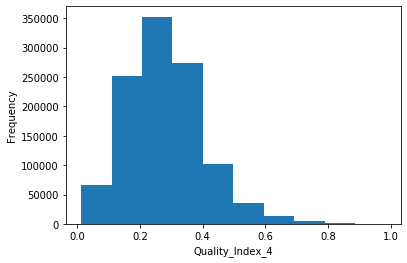

In [12]:
plt.hist(df_merge_quality['quality_index_4'], density=False)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Quality_Index_4');

In [13]:
conditions = [

    (df_merge_quality['quality_index_4'] < 0.3),
    (df_merge_quality['quality_index_4'] >= 0.3)
]

choices = ['0', '1']

In [14]:
import numpy as np
df_merge_quality['quality_rank'] = np.select(condlist=conditions, choicelist=choices)

/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
df_merge_quality

,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,tech_field,...,fwd_cits5,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank
0,US-9111098-B2,An asset management system is provided which c...,20100712,System and method for managing electronic assets,The invention claimed is: \n \n 1. A...,US09111098,330389907,US09111098,2010,6,...,18,42,0,0.657428,0.921539,0.550505,5.0,0.419565,0.372142,1
1,US-9276710-B2,Techniques for supporting communication with c...,20101209,Method and apparatus for resource allocation w...,What is claimed is: \n \n 1. A metho...,US09276710,340923572,US09276710,2010,4,...,26,27,0,0.545600,0.919802,0.269565,6.0,0.469674,0.441058,1
2,US-9353996-B2,A pressure difference driven heat spreader inc...,20100830,Pressure difference driven heat spreader,What is claimed is: \n \n 1. A press...,US09353996,341089247,US09353996,2010,30,...,1,3,0,0.693878,0.786704,0.157895,6.0,0.327714,0.273524,1
3,US-9289847-B2,A manufacturing method for a module having a h...,20100903,Method for manufacturing a module with a hollo...,The invention claimed is: \n \n 1. A...,US09289847,364666123,US09289847,2010,26,...,2,2,0,0.835000,0.910671,0.373134,6.0,0.434408,0.352743,1
4,US-9215628-B2,A method and a system for processing a Radio L...,20100928,Method for processing radio link failure repor...,What is claimed is: \n \n 1. A metho...,US09215628,333088623,US09215628,2010,4,...,37,45,0,0.157116,0.877355,0.327273,5.0,0.228800,0.221936,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103518,US-9420880-B2,An apparatus and assembly for selecting inform...,20141217,Personal control apparatus and method for shar...,What is claimed is: \n \n 1. An appa...,US09420880,438915249,US09420880,2014,2,...,64,64,0,0.899696,0.947995,0.400990,2.0,0.626386,0.664832,1
1103519,US-9610188-B2,An Unloader assembly to control load distribut...,20140918,VRB cantilever-based unloader brace assembly,What is claimed is: \n \n 1. An exos...,US09610188,437249681,US09610188,2014,33,...,5,5,0,0.751378,NaN,NaN,3.0,0.343247,0.309766,1
1103520,US-9222119-B2,Provided herein are compositions useful in det...,20141211,Detection of degradative enzymes and biomolecu...,What is claimed is: \n \n 1. A pepti...,US09222119,438541243,US09222119,2014,15,...,4,4,0,0.719835,0.901745,0.348485,1.0,0.215744,0.288046,0
1103521,US-9253843-B2,"A driving circuit includes a power converter, ...",20141008,Driving circuit with dimming controller for dr...,What is claimed is: \n \n 1. A dimmi...,US09253843,425720739,US09253843,2014,1,...,2,2,0,0.750000,0.869645,0.515748,2.0,0.476945,0.556583,1


In [16]:
df_merge_quality.quality_rank.value_counts()

0    654199
1    449317
Name: quality_rank, dtype: int64

In [17]:
654199/(654199+449317)

0.5928314587192212

In [18]:
df_merge_quality['text'] = df_merge_quality['title_text'] + '. ' + df_merge_quality['abstract_text']

/home/nobu_yamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_merge_quality

,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,tech_field,...,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank,text
0,US-9111098-B2,An asset management system is provided which c...,20100712,System and method for managing electronic assets,The invention claimed is: \n \n 1. A...,US09111098,330389907,US09111098,2010,6,...,42,0,0.657428,0.921539,0.550505,5.0,0.419565,0.372142,1,System and method for managing electronic asse...
1,US-9276710-B2,Techniques for supporting communication with c...,20101209,Method and apparatus for resource allocation w...,What is claimed is: \n \n 1. A metho...,US09276710,340923572,US09276710,2010,4,...,27,0,0.545600,0.919802,0.269565,6.0,0.469674,0.441058,1,Method and apparatus for resource allocation w...
2,US-9353996-B2,A pressure difference driven heat spreader inc...,20100830,Pressure difference driven heat spreader,What is claimed is: \n \n 1. A press...,US09353996,341089247,US09353996,2010,30,...,3,0,0.693878,0.786704,0.157895,6.0,0.327714,0.273524,1,Pressure difference driven heat spreader. A pr...
3,US-9289847-B2,A manufacturing method for a module having a h...,20100903,Method for manufacturing a module with a hollo...,The invention claimed is: \n \n 1. A...,US09289847,364666123,US09289847,2010,26,...,2,0,0.835000,0.910671,0.373134,6.0,0.434408,0.352743,1,Method for manufacturing a module with a hollo...
4,US-9215628-B2,A method and a system for processing a Radio L...,20100928,Method for processing radio link failure repor...,What is claimed is: \n \n 1. A metho...,US09215628,333088623,US09215628,2010,4,...,45,0,0.157116,0.877355,0.327273,5.0,0.228800,0.221936,0,Method for processing radio link failure repor...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103518,US-9420880-B2,An apparatus and assembly for selecting inform...,20141217,Personal control apparatus and method for shar...,What is claimed is: \n \n 1. An appa...,US09420880,438915249,US09420880,2014,2,...,64,0,0.899696,0.947995,0.400990,2.0,0.626386,0.664832,1,Personal control apparatus and method for shar...
1103519,US-9610188-B2,An Unloader assembly to control load distribut...,20140918,VRB cantilever-based unloader brace assembly,What is claimed is: \n \n 1. An exos...,US09610188,437249681,US09610188,2014,33,...,5,0,0.751378,NaN,NaN,3.0,0.343247,0.309766,1,VRB cantilever-based unloader brace assembly. ...
1103520,US-9222119-B2,Provided herein are compositions useful in det...,20141211,Detection of degradative enzymes and biomolecu...,What is claimed is: \n \n 1. A pepti...,US09222119,438541243,US09222119,2014,15,...,4,0,0.719835,0.901745,0.348485,1.0,0.215744,0.288046,0,Detection of degradative enzymes and biomolecu...
1103521,US-9253843-B2,"A driving circuit includes a power converter, ...",20141008,Driving circuit with dimming controller for dr...,What is claimed is: \n \n 1. A dimmi...,US09253843,425720739,US09253843,2014,1,...,2,0,0.750000,0.869645,0.515748,2.0,0.476945,0.556583,1,Driving circuit with dimming controller for dr...


In [22]:
data_train = df_merge_quality.sample(frac=1)[:5000]
data_train

,publication_number,abstract_text,filing_date,title_text,claims_text,publication_number_match,appln_id,pub_nbr,filing,tech_field,...,fwd_cits7,breakthrough,generality,originality,radicalness,renewal,quality_index_4,quality_index_6,quality_rank,text
570905,US-9062045-B2,The invention relates to compounds of formula ...,20120913,Triazolopyridine compounds,We claim: \n \n 1. A compound of for...,US09062045,410465421,US09062045,2012,16,...,3,0,0.586420,0.904564,0.344037,3.0,0.313098,0.400443,1,Triazolopyridine compounds. The invention rela...
463180,US-8795158-B2,An insertion assisting device includes a rotar...,20120425,Endoscope insertion assisting device,What is claimed is: \n \n 1. An endo...,US08795158,376649740,US08795158,2012,13,...,2,0,0.000000,0.652800,0.280000,2.0,0.087627,0.172554,0,Endoscope insertion assisting device. An inser...
454954,US-9216926-B2,A method for producing a reaction product incl...,20120607,Synthetic formulations and methods of manufact...,What is claimed is: \n \n 1. A meth...,US09216926,378955471,US09216926,2012,20,...,24,0,0.744521,0.931914,0.733524,3.0,0.652708,0.622020,1,Synthetic formulations and methods of manufact...
280623,US-9177112-B2,A method for establishing a secured communicat...,20110511,Method and device for communicating digital co...,The invention claimed is: \n \n 1. A...,US09177112,381255584,US09177112,2011,6,...,3,0,0.500000,0.845203,0.065574,4.0,0.270587,0.259567,0,Method and device for communicating digital co...
16993,US-8504204-B2,"A method, system and apparatus to position an ...",20100722,Automated positioning of an organic polarized ...,What is claimed is: \n \n 1. A metho...,US08504204,341093799,US08504204,2010,29,...,3,0,0.826111,0.934499,0.740741,7.0,0.292891,0.326054,0,Automated positioning of an organic polarized ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157259,US-7921858-B2,An apparatus for transporting an object from o...,20100329,Self-cleaning adhesive structure and methods,1. Apparatus for transporting an object from o...,US07921858,319385082,US07921858,2010,23,...,44,0,0.859331,0.969531,0.950000,4.0,0.479242,0.484279,1,Self-cleaning adhesive structure and methods. ...
587321,US-9401611-B2,Method for recharging a pool of batteries from...,20120726,Recharging of a pool of batteries,The invention claimed is: \n \n 1. M...,US09401611,419182731,US09401611,2012,1,...,1,0,0.000000,0.857208,0.606061,4.0,0.187943,0.207348,0,Recharging of a pool of batteries. Method for ...
335565,US-9034268-B2,An internal combustion engine wherein a hydroc...,20111107,Exhaust purification system of internal combus...,The invention claimed is: \n \n 1. A...,US09034268,406147454,US09034268,2011,24,...,0,0,NaN,0.751915,0.297619,4.0,0.237500,0.431104,0,Exhaust purification system of internal combus...
528590,US-8686494-B2,The disclosed recessed thyristor-based memory ...,20120216,Recessed channel negative differential resista...,What is claimed is: \n \n 1. A devic...,US08686494,406993467,US08686494,2012,8,...,4,0,0.000000,0.787056,0.182243,2.0,0.425841,0.440133,1,Recessed channel negative differential resista...


In [21]:
data_train.to_csv('US_patent_abstract_5000_2015_with_title_1_5y.csv')

In [23]:
data_train.to_csv('US_patent_abstract_5000_2015_with_title_2_5y.csv')

In [27]:
data_train = df_merge_quality.sample(frac=1)[:50000]

In [28]:
data_train.to_csv('US_patent_abstract_50000_2015_with_title_1_5y.csv')

In [26]:
data_train.to_csv('US_patent_abstract_50000_2015_with_title_2_5y.csv')